In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
customers=pd.read_csv("Customers.csv")
products=pd.read_csv("Products.csv")
transactions=pd.read_csv("Transactions.csv")

In [5]:
products=products.drop('Price', axis=1)
df=transactions.merge(products,on="ProductID",how='left')
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,ProductName,Category
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving Bluetooth Speaker,Electronics
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving Bluetooth Speaker,Electronics


In [6]:
# Aggregate transaction data (e.g., total spending, products purchased)
transaction_summary = df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Category': lambda x: ','.join(x)  # Concatenate product categories
}).reset_index()
transaction_summary.head()

,CustomerID,TotalValue,Quantity,Category
0,C0001,3354.52,12,"Books,Home Decor,Electronics,Electronics,Elect..."
1,C0002,1862.74,10,"Home Decor,Home Decor,Clothing,Clothing"
2,C0003,2725.38,14,"Home Decor,Home Decor,Clothing,Electronics"
3,C0004,5354.88,23,"Books,Home Decor,Home Decor,Home Decor,Books,B..."
4,C0005,2034.24,7,"Home Decor,Electronics,Electronics"


In [7]:
# Merge with customer data
data = pd.merge(customers, transaction_summary, on='CustomerID', how='left')

In [8]:
data.isnull().count()

CustomerID      200
CustomerName    200
Region          200
SignupDate      200
TotalValue      200
Quantity        200
Category        200
dtype: int64

In [9]:
# Encode categorical variables

data.fillna(0, inplace=True)
le_region = LabelEncoder()
data['Region'] = le_region.fit_transform(data['Region'])
data['Category'] = data['Category'].astype('category').cat.codes
data.head()

,CustomerID,CustomerName,Region,SignupDate,TotalValue,Quantity,Category
0,C0001,Lawrence Carroll,3,2022-07-10,3354.52,12.0,53
1,C0002,Elizabeth Lutz,0,2022-02-13,1862.74,10.0,171
2,C0003,Michael Rivera,3,2024-03-07,2725.38,14.0,173
3,C0004,Kathleen Rodriguez,3,2022-10-09,5354.88,23.0,59
4,C0005,Laura Weber,0,2022-08-15,2034.24,7.0,162


In [10]:
# Select features for similarity calculation
features = ['Region', 'TotalValue', 'Quantity', 'Category']
X = data[features]


In [11]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [12]:
# Find the optimal number of clusters (2 to 10)
db_scores = []
silhouette_scores = []
inertia_scores = []

In [13]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Calculate metrics
    db_index = davies_bouldin_score(X_scaled, cluster_labels)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    inertia = kmeans.inertia_
    
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)
    inertia_scores.append(inertia)


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

In [14]:
# Select the best number of clusters based on DB Index
optimal_k = db_scores.index(min(db_scores)) + 2
print(f"Optimal number of clusters (based on DB Index): {optimal_k}")

# Final K-Means model
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataset
data['Cluster'] = final_labels


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Optimal number of clusters (based on DB Index): 10


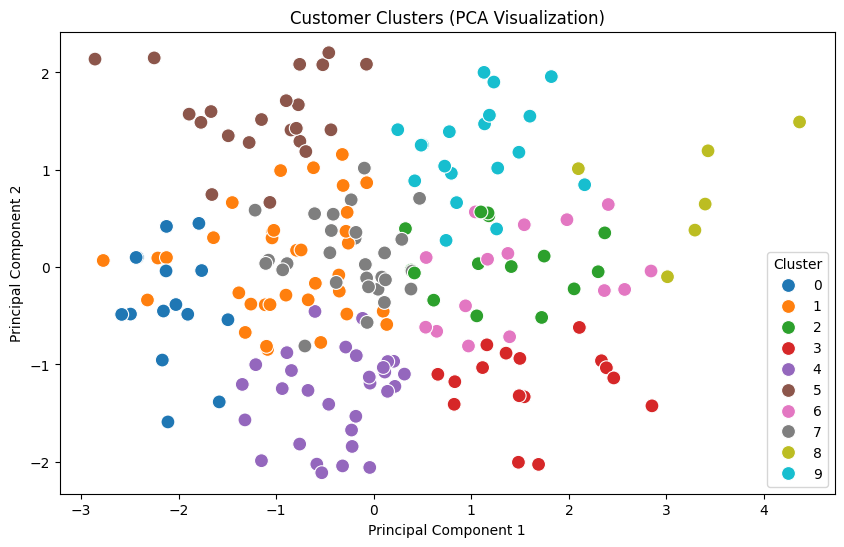

[[ 0.04344615 -0.22698519]
 [-1.1134572  -0.38678201]
 [-0.04150618 -2.05810046]
 [ 2.05315265 -0.22334432]
 [-1.38341524 -0.26390666]
 [ 0.38392173 -0.02982791]
 [-1.03753731  0.36142205]
 [ 1.15912859 -0.79827714]
 [-2.12529278  0.41857472]
 [-0.75758762  1.29296078]
 [ 0.32439068  0.39563659]
 [ 1.48252364 -2.00465834]
 [ 1.72078814 -0.51680094]
 [-2.49428613 -0.48216302]
 [-1.79278553  0.44964   ]
 [-0.11537991 -0.52628662]
 [ 1.37474371  0.14088183]
 [ 1.17889134  0.52697061]
 [-0.69664076  1.18774161]
 [-2.02853088 -0.38455507]
 [ 1.12971482  2.00099387]
 [ 0.53672201  0.09883408]
 [ 0.74062145  0.27494538]
 [ 0.21641179 -1.22493789]
 [-1.15184695 -1.98859917]
 [-0.03876957 -1.1918972 ]
 [-0.52294244  2.07941226]
 [ 2.40347051  0.6433439 ]
 [-0.88925469  0.03608398]
 [-0.23225288  0.69169198]
 [-0.75999087 -1.81773162]
 [-1.76464878 -0.03513318]
 [-2.42382267  0.10108488]
 [ 0.39202713 -0.040507  ]
 [-0.60300224 -0.45513271]
 [-1.07951791  0.07183096]
 [ 0.41941522  0.88668067]
 

In [15]:

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
plot_data = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_data['Cluster'] = final_labels

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=plot_data, palette='tab10', s=100)
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

print(X_pca)

In [16]:
# Final DB Index
final_db_index = davies_bouldin_score(X_scaled, final_labels)


# Silhouette Score
final_silhouette_score = silhouette_score(X_scaled, final_labels)

# Clustering Summary
print(f"Number of Clusters: {optimal_k}")
print(f"DB Index: {final_db_index}")
print(f"Silhouette Score: {final_silhouette_score}")

Number of Clusters: 10
DB Index: 0.992491840434693
Silhouette Score: 0.2845517813776643


In [17]:
# Add the cluster labels to the customer dataset
data['Cluster'] = final_labels

# Now, let's map customer IDs to their corresponding cluster label
customer_cluster_mapping = data[['CustomerID', 'Cluster']]

# Display the first few rows to check the result
print(customer_cluster_mapping.head())

# If you want to save this mapping to a CSV
customer_cluster_mapping.to_csv("Customer_Cluster_Assignment.csv", index=False)

  CustomerID  Cluster
0      C0001        7
1      C0002        1
2      C0003        4
3      C0004        2
4      C0005        1
